In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras
tf.config.run_functions_eagerly(False)

from tensorflow.keras.optimizers.schedules import CosineDecay
from sklearn.model_selection import GroupShuffleSplit
from tensorflow.keras import layers, models, losses, metrics
from tensorflow.keras import regularizers, callbacks
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LeakyReLU, Reshape, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten, Activation, Add, Input, GlobalAveragePooling1D, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.utils import plot_model

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()

    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)

    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life

    # Drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

def add_operating_condition(df):
    df_op_cond = df.copy()

    df_op_cond['setting_1'] = abs(df_op_cond['setting_1'].round())
    df_op_cond['setting_2'] = abs(df_op_cond['setting_2'].round(decimals=2))

    # Converting settings to string and concatanating makes the operating condition into a categorical variable
    df_op_cond['op_cond'] = df_op_cond['setting_1'].astype(str) + '_' + \
                        df_op_cond['setting_2'].astype(str) + '_' + \
                        df_op_cond['setting_3'].astype(str)

    return df_op_cond

def condition_scaler(df_train, df_test, sensor_names):
    # Apply operating condition specific scaling
    scaler = StandardScaler()
    for condition in df_train['op_cond'].unique():
        scaler.fit(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_test.loc[df_test['op_cond']==condition, sensor_names] = scaler.transform(df_test.loc[df_test['op_cond']==condition, sensor_names])
    return df_train, df_test

def exponential_smoothing(df, sensors, n_samples, alpha=0.4):
    df = df.copy()
    # Take the exponential weighted mean
    df[sensors] = df.groupby('unit_nr')[sensors].apply(lambda x: x.ewm(alpha=alpha).mean()).reset_index(level=0, drop=True)

    # Drop first n_samples of each unit_nr to reduce filter delay
    def create_mask(data, samples):
        result = np.ones_like(data)
        result[0:samples] = 0
        return result

    mask = df.groupby('unit_nr')['unit_nr'].transform(create_mask, samples=n_samples).astype(bool)
    df = df[mask]

    return df

def gen_train_data(df, sequence_length, columns):
    data = df[columns].values
    num_elements = data.shape[0]

    for start, stop in zip(range(0, num_elements-(sequence_length-1)), range(sequence_length, num_elements+1)):
        yield data[start:stop, :]

def gen_data_wrapper(df, sequence_length, columns, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['unit_nr'].unique()

    data_gen = (list(gen_train_data(df[df['unit_nr']==unit_nr], sequence_length, columns))
               for unit_nr in unit_nrs)
    data_array = np.concatenate(list(data_gen)).astype(np.float32)
    return data_array

def gen_labels(df, sequence_length, label):
    data_matrix = df[label].values
    num_elements = data_matrix.shape[0]

    return data_matrix[sequence_length-1:num_elements, :]

def gen_label_wrapper(df, sequence_length, label, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['unit_nr'].unique()

    label_gen = [gen_labels(df[df['unit_nr']==unit_nr], sequence_length, label)
                for unit_nr in unit_nrs]
    label_array = np.concatenate(label_gen).astype(np.float32)
    return label_array

def gen_test_data(df, sequence_length, columns, mask_value):
    if df.shape[0] < sequence_length:
        data_matrix = np.full(shape=(sequence_length, len(columns)), fill_value=mask_value)
        idx = data_matrix.shape[0] - df.shape[0]
        data_matrix[idx:,:] = df[columns].values
    else:
        data_matrix = df[columns].values

    stop = data_matrix.shape[0]
    start = stop - sequence_length
    for i in list(range(1)):
        yield data_matrix[start:stop, :]


def get_data(dataset, sensors, sequence_length, alpha, threshold):
	dir_path = './CMAPSS/'
	train_file = 'train_'+dataset+'.txt'
	test_file = 'test_'+dataset+'.txt'

	index_names = ['unit_nr', 'time_cycles']
	setting_names = ['setting_1', 'setting_2', 'setting_3']
	sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
	col_names = index_names + setting_names + sensor_names

	train = pd.read_csv((dir_path+train_file), sep=r'\s+', header=None,
					 names=col_names)
	test = pd.read_csv((dir_path+test_file), sep=r'\s+', header=None,
					 names=col_names)
	y_test = pd.read_csv((dir_path+'RUL_'+dataset+'.txt'), sep=r'\s+', header=None,
					 names=['RemainingUsefulLife'])

	train = add_remaining_useful_life(train)
	train['RUL'].clip(upper=threshold, inplace=True)

  #Dropping sensors
	drop_sensors = [element for element in sensor_names if element not in sensors]

  # Scale with respect to the operating condition
	X_train_pre = add_operating_condition(train.drop(drop_sensors, axis=1))
	X_test_pre = add_operating_condition(test.drop(drop_sensors, axis=1))
	X_train_pre, X_test_pre = condition_scaler(X_train_pre, X_test_pre, sensors)

  # Exponential smoothing
	X_train_pre= exponential_smoothing(X_train_pre, sensors, 0, alpha)
	X_test_pre = exponential_smoothing(X_test_pre, sensors, 0, alpha)

  # Train/Validation split
	gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)

	for train_unit, val_unit in gss.split(X_train_pre['unit_nr'].unique(), groups=X_train_pre['unit_nr'].unique()):
		train_unit = X_train_pre['unit_nr'].unique()[train_unit]  # gss returns indexes and index starts at 1
		val_unit = X_train_pre['unit_nr'].unique()[val_unit]

		x_train = gen_data_wrapper(X_train_pre, sequence_length, sensors, train_unit)
		y_train = gen_label_wrapper(X_train_pre, sequence_length, ['RUL'], train_unit)

		x_val = gen_data_wrapper(X_train_pre, sequence_length, sensors, val_unit)
		y_val = gen_label_wrapper(X_train_pre, sequence_length, ['RUL'], val_unit)

	# Create sequences for test
	test_gen = (list(gen_test_data(X_test_pre[X_test_pre['unit_nr']==unit_nr], sequence_length, sensors, -99.))
			   for unit_nr in X_test_pre['unit_nr'].unique())
	x_test = np.concatenate(list(test_gen)).astype(np.float32)
	test_unit_ids = X_test_pre['unit_nr'].unique()

	return x_train, y_train, x_val, y_val, x_test, y_test['RemainingUsefulLife'], test_unit_ids

In [54]:
# Choose the subset (FD001, FD002, FD003, FD004)
dataset = 'FD002'

# Sensors to use; sensor 13 is dropped from FD002 and FD004

if(dataset == 'FD001' or 'FD003'):
  sensors = ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']
else:
  sensors = ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 's_12', 's_14', 's_15', 's_17', 's_20', 's_21']

sequence_length = 30
alpha = 0.3
rul_clip_threshold = 125

# Load and process the data
x_train, y_train, x_val, y_val, x_test, y_test, test_unit_ids = get_data(
    dataset=dataset,
    sensors=sensors,
    sequence_length=sequence_length,
    alpha=alpha,
    threshold=rul_clip_threshold
)

<ipython-input-39-edafd160830c>:118: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['RUL'].clip(upper=threshold, inplace=True)
<ipython-input-39-edafd160830c>:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.1674041  -1.59188977 -0.1674041  ...  0.54483874  1.96932442
  2.68156725]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scale

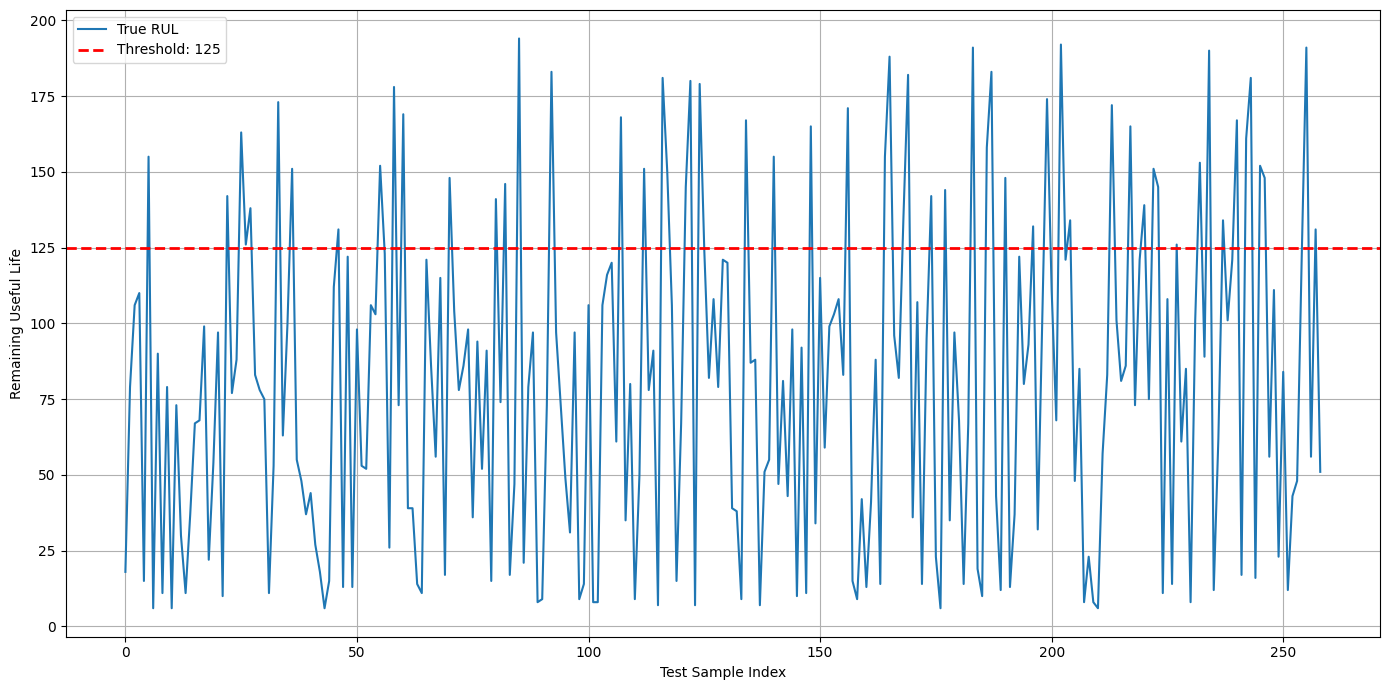

In [57]:
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='True RUL')
plt.axhline(y=125, color='red', linestyle='--', linewidth=2, label='Threshold: 125')
plt.xlabel('Test Sample Index')
plt.ylabel('Remaining Useful Life')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [41]:
# Positional Encoding
class PositionalEncodingLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(PositionalEncodingLayer, self).__init__(**kwargs)

    def call(self, x):
        seq_len = tf.shape(x)[1]
        d_model = tf.shape(x)[2]
        pos = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis]
        i = tf.range(d_model, dtype=tf.float32)[tf.newaxis, :]
        angle_rates = 1 / tf.pow(10000.0, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        angle_rads = pos * angle_rates
        sines = tf.sin(angle_rads[:, 0::2])
        cosines = tf.cos(angle_rads[:, 1::2])
        pos_encoding = tf.concat([sines, cosines], axis=-1)
        return x + pos_encoding[tf.newaxis, :, :]

    def get_config(self):
        config = super(PositionalEncodingLayer, self).get_config()
        return config

# CBAM Block
def cbam_block(x, reduction_ratio=8):
    input_channels = x.shape[-1]

    # Channel Attention
    avg_pool = layers.GlobalAveragePooling1D()(x)
    max_pool = layers.GlobalMaxPooling1D()(x)

    shared_dense_1 = layers.Dense(input_channels // reduction_ratio, activation='relu')
    shared_dense_2 = layers.Dense(input_channels)

    avg_out = shared_dense_2(shared_dense_1(avg_pool))
    max_out = shared_dense_2(shared_dense_1(max_pool))

    channel_attention = layers.Add()([avg_out, max_out])
    channel_attention = layers.Activation('sigmoid')(channel_attention)
    channel_attention = layers.Reshape((1, input_channels))(channel_attention)

    x = layers.Multiply()([x, channel_attention])

    # Spatial Attention
    avg_pool_spatial = layers.Lambda(lambda z: tf.reduce_mean(z, axis=-1, keepdims=True))(x)
    max_pool_spatial = layers.Lambda(lambda z: tf.reduce_max(z, axis=-1, keepdims=True))(x)
    concat = layers.Concatenate(axis=-1)([avg_pool_spatial, max_pool_spatial])
    spatial_attention = layers.Conv1D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)

    x = layers.Multiply()([x, spatial_attention])
    return x


# Residual Dilated CNN Block
def residual_dilated_conv_block(x, filters, kernel_size, dilation_rate):
    shortcut = x
    x = layers.Conv1D(filters, kernel_size, padding='same', dilation_rate=dilation_rate)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv1D(filters, kernel_size, padding='same', dilation_rate=dilation_rate)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Add()([shortcut, x]) if shortcut.shape[-1] == x.shape[-1] else layers.Conv1D(filters, 1)(shortcut) + x
    x = layers.Activation('relu')(x)
    return x

# Transformer Block (MultiHead Attention)
def transformer_block(x, num_heads=4, ff_dim=128):
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=x.shape[-1])(x, x)
    attn_output = layers.Dropout(0.3)(attn_output)
    out1 = layers.LayerNormalization()(x + attn_output)
    ffn = layers.Dense(ff_dim, activation='relu')(out1)
    ffn = layers.Dense(x.shape[-1])(ffn)
    ffn = layers.Dropout(0.3)(ffn)
    return layers.LayerNormalization()(out1 + ffn)

# Model Definition
def create_bilstm_cnn_hybrid_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = PositionalEncodingLayer()(inputs)

    # BiLSTM Stack
    x = layers.Bidirectional(layers.LSTM(96, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(48, return_sequences=True))(x)

    # Transformer Block
    x = transformer_block(x)

    # CNN Blocks
    x = residual_dilated_conv_block(x, filters=64, kernel_size=5, dilation_rate=1)
    x = residual_dilated_conv_block(x, filters=32, kernel_size=5, dilation_rate=2)
    x = cbam_block(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu',
                     kernel_regularizer=regularizers.l2(1e-5))(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1)(x)

    model = models.Model(inputs, outputs)
    return model


In [ ]:
# AdamW optimizer with weight decay
optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0005668473, weight_decay=1e-05)

# Compile the model
model = create_bilstm_cnn_hybrid_model(input_shape=(x_train.shape[1], x_train.shape[2]))
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.Huber(),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

model.summary()

early_stop = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop]
)

model.load_weights('./weights/FD001.weights.h5')

predictions = model.predict(x_test).flatten()
rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
print(f'Test RMSE (FD001): {rmse:.2f}')

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 30, 14)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, 30, 14)    │          0 │ input_layer_12[0… │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_24    │ (None, 30, 192)   │     85,248 │ positional_encod… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_25    │ (None, 30, 96)    │     92,544 │ bidirectional_24… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 96)    │    148,704 │ bidirectional_25… │
│ (MultiHeadAttentio… │                   │            │ bidirectional_25… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_97          │ (None, 30, 96)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_59 (Add)        │ (None, 30, 96)    │          0 │ bidirectional_25… │
│                     │                   │            │ dropout_97[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 96)    │        192 │ add_59[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_72 (Dense)    │ (None, 30, 128)   │     12,416 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_73 (Dense)    │ (None, 30, 96)    │     12,384 │ dense_72[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_98          │ (None, 30, 96)    │          0 │ dense_73[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_60 (Add)        │ (None, 30, 96)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_98[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 96)    │        192 │ add_60[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_84 (Conv1D)  │ (None, 30, 64)    │     30,784 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 64)    │        128 │ conv1d_84[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_99          │ (None, 30, 64)    │          0 │ layer_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_59       │ (None, 30, 64)    │          0 │ dropout_99[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_85 (Conv1D)  │ (None, 30, 64)    │     20,544 │ activation_59[0]

 Total params: 429,588 (1.64 MB)

 Trainable params: 429,588 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 105s 44ms/step - loss: 52.9834 - root_mean_squared_error: 66.6123 - val_loss: 9.5295 - val_root_mean_squared_error: 14.5444
Epoch 2/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 13.8943 - root_mean_squared_error: 19.2686 - val_loss: 8.0001 - val_root_mean_squared_error: 12.8229
Epoch 3/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - loss: 13.0925 - root_mean_squared_error: 18.2210 - val_loss: 9.5044 - val_root_mean_squared_error: 13.9770
Epoch 4/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 12.1742 - root_mean_squared_error: 17.1430 - val_loss: 9.0178 - val_root_mean_squared_error: 13.1547
Epoch 5/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 12.2147 - root_mean_squared_error: 17.2081 - val_loss: 7.9578 - val_root_mean_squared_error: 12.5510
Epoch 6/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 11.5293 - root_mean_squared_error: 16.2434 - val_loss: 7.6815 - val_root_mean_squared_error: 12.5009
Epoch 7/50
223/223 ━━━━

In [ ]:
# AdamW optimizer with weight decay
optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0005668473, weight_decay=1e-05)

# Compile the model
model = create_bilstm_cnn_hybrid_model(input_shape=(x_train.shape[1], x_train.shape[2]))
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.Huber(),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

early_stop = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop]
)

model.load_weights('./weights/FD002.weights.h5')

predictions = model.predict(x_test).flatten()
rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
print(f'Test RMSE (FD002): {rmse:.2f}')

Epoch 1/50
585/585 ━━━━━━━━━━━━━━━━━━━━ 32s 35ms/step - loss: 49.5409 - root_mean_squared_error: 64.6518 - val_loss: 17.3915 - val_root_mean_squared_error: 21.8213
Epoch 2/50
585/585 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - loss: 14.3663 - root_mean_squared_error: 19.8936 - val_loss: 11.5988 - val_root_mean_squared_error: 16.5863
Epoch 3/50
585/585 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - loss: 13.8495 - root_mean_squared_error: 19.2667 - val_loss: 14.5696 - val_root_mean_squared_error: 21.1308
Epoch 4/50
585/585 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - loss: 13.5575 - root_mean_squared_error: 18.9703 - val_loss: 12.2976 - val_root_mean_squared_error: 18.5891
Epoch 5/50
585/585 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - loss: 13.1777 - root_mean_squared_error: 18.5712 - val_loss: 10.2475 - val_root_mean_squared_error: 15.3697
Epoch 6/50
585/585 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - loss: 13.0841 - root_mean_squared_error: 18.2681 - val_loss: 13.3379 - val_root_mean_squared_error: 19.0232
Epoch 7/50
585/5

In [ ]:
# AdamW optimizer with weight decay
optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0005668473, weight_decay=1e-05)

# Compile the model
model = create_bilstm_cnn_hybrid_model(input_shape=(x_train.shape[1], x_train.shape[2]))
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.Huber(),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

early_stop = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop]
)

model.load_weights('./weights/FD003.weights.h5')

predictions = model.predict(x_test).flatten()
rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
print(f'Test RMSE (FD003): {rmse:.2f}')

Epoch 1/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 23s 40ms/step - loss: 48.4356 - root_mean_squared_error: 61.6552 - val_loss: 9.2094 - val_root_mean_squared_error: 13.9961
Epoch 2/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - loss: 14.8354 - root_mean_squared_error: 20.1617 - val_loss: 8.5216 - val_root_mean_squared_error: 13.6333
Epoch 3/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 13.7632 - root_mean_squared_error: 18.8589 - val_loss: 8.2760 - val_root_mean_squared_error: 12.8648
Epoch 4/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 13.1588 - root_mean_squared_error: 18.2009 - val_loss: 9.0428 - val_root_mean_squared_error: 13.1892
Epoch 5/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 12.6353 - root_mean_squared_error: 17.6448 - val_loss: 7.1590 - val_root_mean_squared_error: 12.1000
Epoch 6/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 12.6455 - root_mean_squared_error: 17.5732 - val_loss: 8.2680 - val_root_mean_squared_error: 13.7132
Epoch 7/50
277/277 ━━━━━

In [ ]:
# AdamW optimizer with weight decay
optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0005668473, weight_decay=1e-05)

# Compile the model
model = create_bilstm_cnn_hybrid_model(input_shape=(x_train.shape[1], x_train.shape[2]))
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.Huber(),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

early_stop = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop]
)

model.load_weights('./weights/FD004.weights.h5')

predictions = model.predict(x_test).flatten()
rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
print(f'Test RMSE (FD004): {rmse:.2f}')

Epoch 1/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 39s 37ms/step - loss: 35.9272 - root_mean_squared_error: 48.9074 - val_loss: 13.0924 - val_root_mean_squared_error: 20.5056
Epoch 2/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - loss: 14.4798 - root_mean_squared_error: 20.0600 - val_loss: 12.7353 - val_root_mean_squared_error: 19.6953
Epoch 3/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - loss: 13.8017 - root_mean_squared_error: 19.3910 - val_loss: 12.4383 - val_root_mean_squared_error: 19.0062
Epoch 4/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 42s 35ms/step - loss: 13.0680 - root_mean_squared_error: 18.4345 - val_loss: 12.4192 - val_root_mean_squared_error: 19.0770
Epoch 5/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - loss: 13.0102 - root_mean_squared_error: 18.4351 - val_loss: 11.5748 - val_root_mean_squared_error: 18.1001
Epoch 6/50
681/681 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - loss: 12.6341 - root_mean_squared_error: 18.0655 - val_loss: 12.5649 - val_root_mean_squared_error: 19.3461
Epoch 7/50
681/6

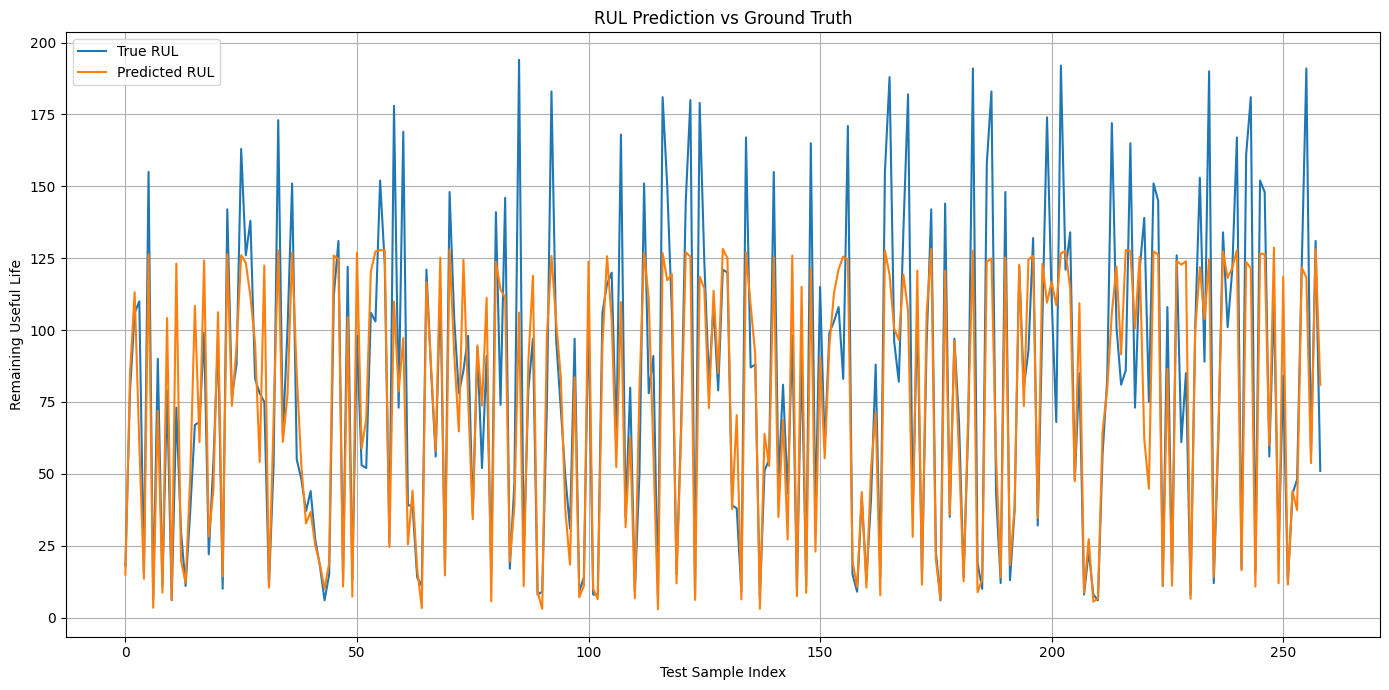

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='True RUL')
plt.plot(predictions, label='Predicted RUL')
plt.xlabel('Test Sample Index')
plt.ylabel('Remaining Useful Life')
plt.title('RUL Prediction vs Ground Truth')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


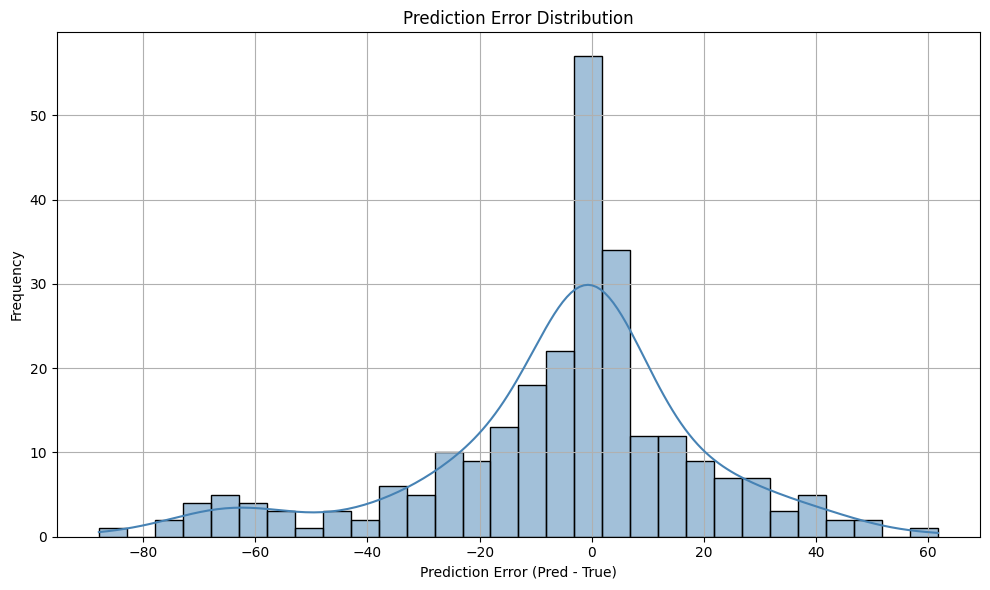

In [ ]:
errors = predictions - y_test

plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True, bins=30, color='steelblue')
plt.title("Prediction Error Distribution")
plt.xlabel("Prediction Error (Pred - True)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

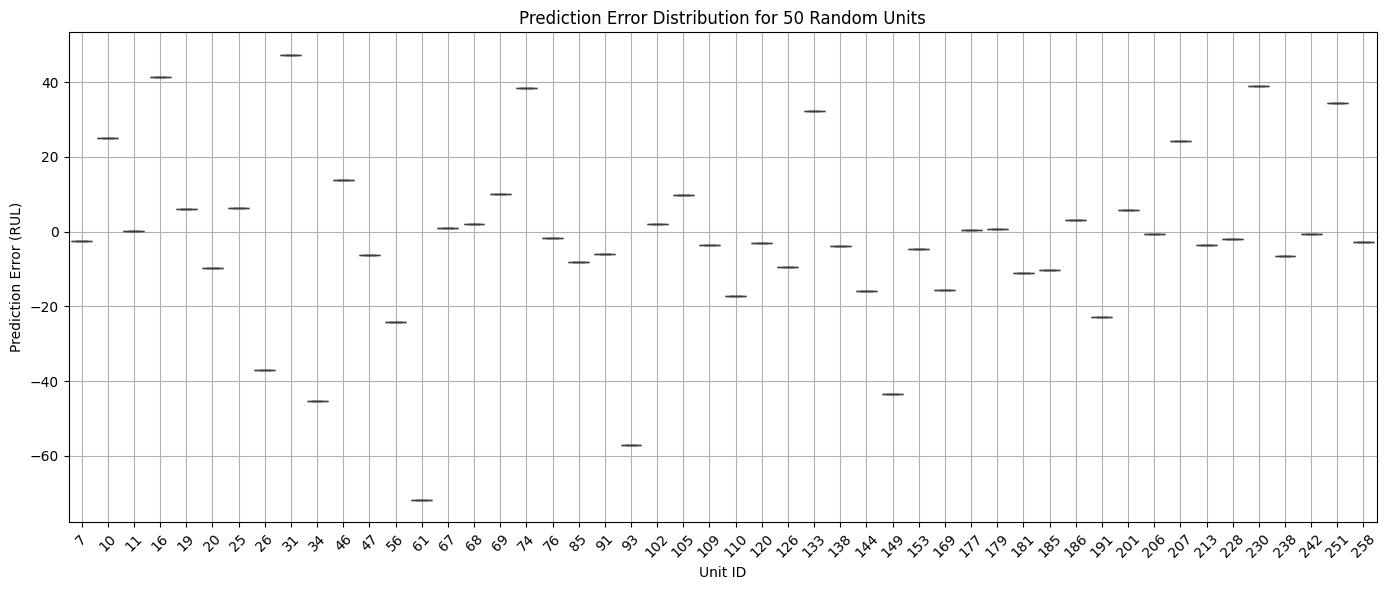

In [ ]:
def plot_sampled_unit_errors(y_true, y_pred, unit_ids, sample_size=20, random_state=42):
    # Compute errors
    errors = y_pred - y_true

    # Prepare DataFrame
    df = pd.DataFrame({
        'unit_id': unit_ids,
        'error': errors
    })

    # Sample a subset of unit IDs
    sampled_unit_ids = np.random.RandomState(seed=random_state).choice(
        df['unit_id'].unique(), size=sample_size, replace=False
    )

    sampled_df = df[df['unit_id'].isin(sampled_unit_ids)]

    # Plot
    plt.figure(figsize=(14, 6))
    sns.boxplot(x='unit_id', y='error', data=sampled_df)
    plt.xticks(rotation=45)
    plt.title(f'Prediction Error Distribution for {sample_size} Random Units')
    plt.ylabel('Prediction Error (RUL)')
    plt.xlabel('Unit ID')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_sampled_unit_errors(y_test.values, predictions, test_unit_ids, sample_size=50)

In [56]:
!pip install visualkeras
import visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 20.9 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


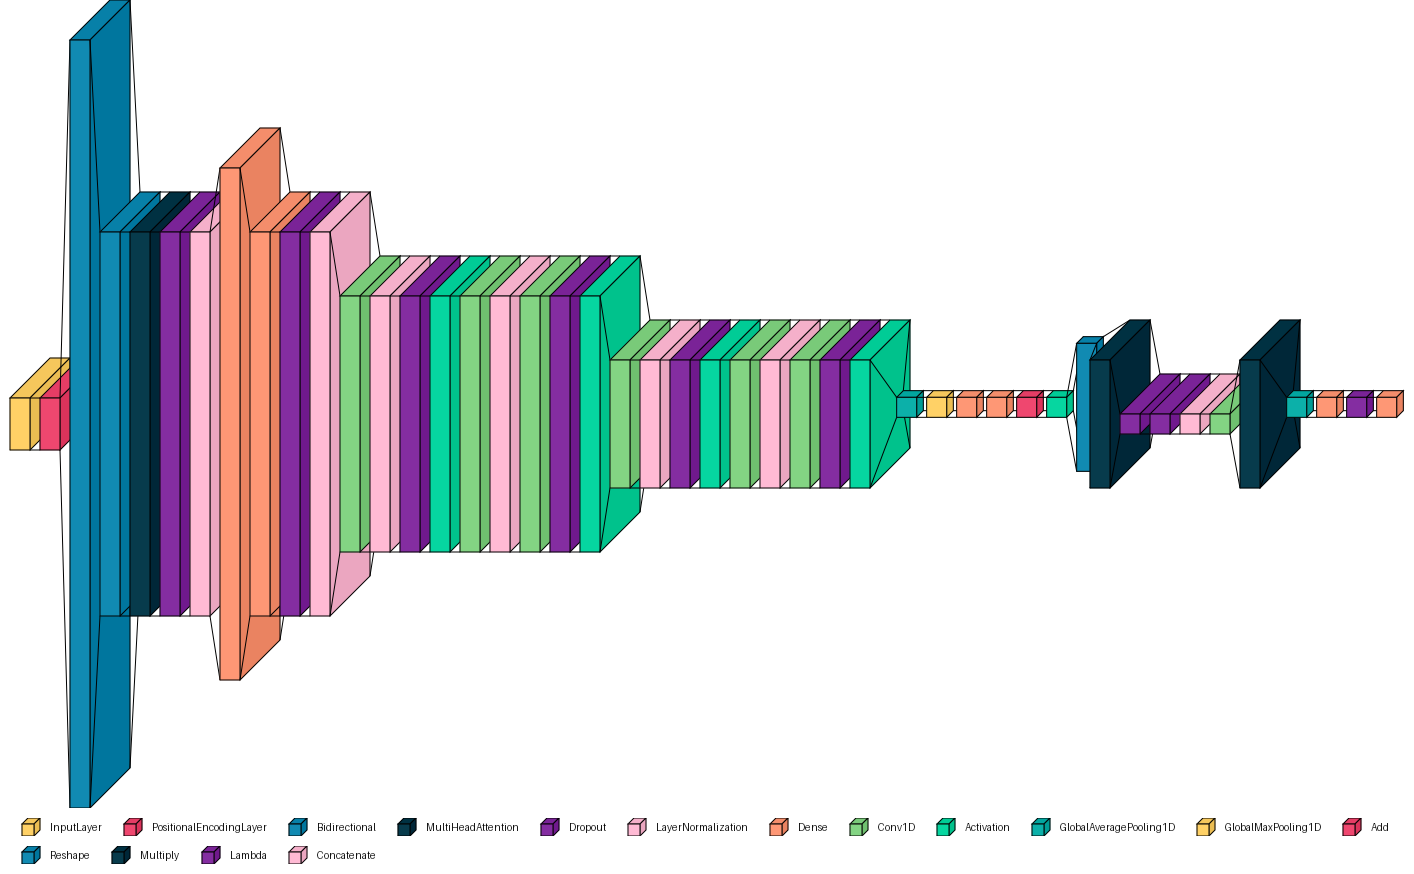

In [ ]:
visualkeras.layered_view(model, draw_volume=True, legend=True)

In [ ]:
import PIL
from collections import defaultdict
import matplotlib.patches as mpatches

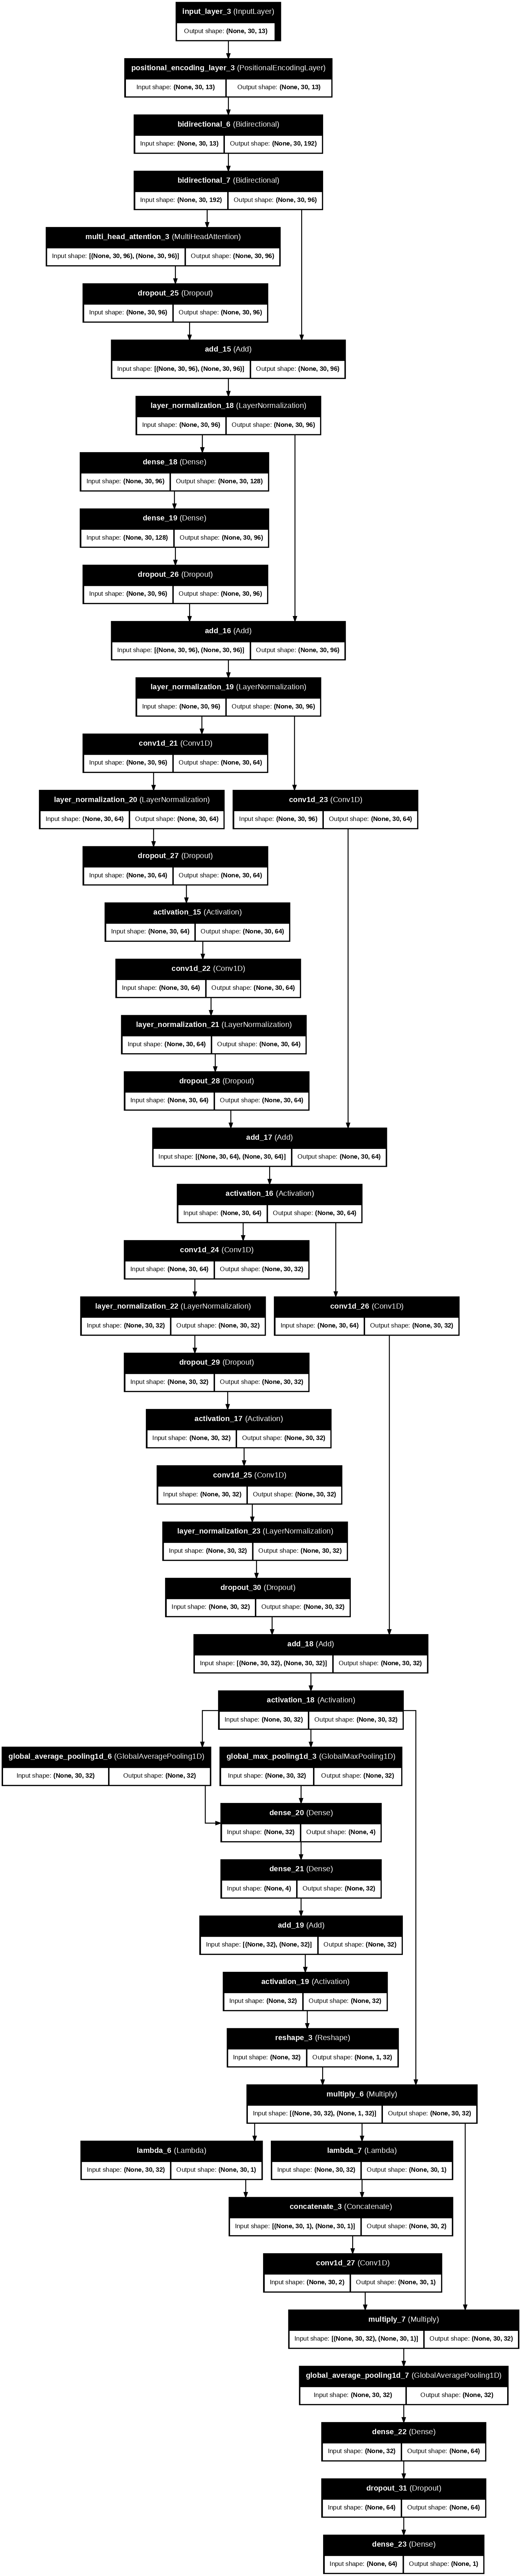

In [ ]:
plot_model(model, to_file="model_architecture.png", show_shapes=True, show_layer_names=True, expand_nested=True, dpi=100)